# Atmospheric modelling

Following on from the cloud simulations and PCA of the cloud spectrum we are next going to attempt to emulate the libRadtran atmospheric model. Before we do that we first have to inspect the parameter space over which the model will have to simulate transmittance, atmospheric path reflectance and spherical albedo. These are the three variables we need for our forward model of TOA reflectance given in addition a certain surface reflectance. The parameter space will be inspected by setting up a 3D grid with 2 varying parameters on the x and y axis, and either the integral of reflectance over a spectral region or the reflectance at a specific wavelength as the z axis, or even the difference or normalized difference between inside the absorption band and outside. The covariance of parameters can thus be inspected. The parameters we need for our model are: water vapour content (WVC), aerosol optical thickness (AOT) at 550 nm, surface pressure (press). Altitude is not included as this is a prescribed parameter and will have a similar effect to surface pressure on the spectrum. View and solar directions are also not included as these are also prescribed and each configuration of view and solar angle will require a separate emulator, thus not be included in the modelled surface within each emulator. 

After the simulation of some covariance between parameters to see its affect on atmospheric variables, we need to create a Gaussian process emulator (GPE) of the TOA reflectance based on the Chandrasekhar equation using double transmittance ($TT$), spherical albedo ($\alpha$) and atmospheric path reflectance ($\rho_{atm}$) as well as the surface reflectance ($\rho_{surf}$). Surface reflectance is a function of a and p, where a is the product of canopy interceptance ($i_0$) and directional gap density ($\rho(\Omega)$), and p is the recollision probability. Thus is will be done over the full expected parameter space range. A literature review and where possible auxiliary datasets will provide some insight into ranges and possibly distributions of parameters used. This was done as part of the cloud PCA and these distributions can be used again. Altitude was not included but can be included this time with a new analysis of altitude ranges. A global DTM can be loaded and altitudes can be binned to estimate a distribution type. These distributions are used to recreate a dataset of expected values by sampling from these distributions. 250 parameter combinations were randomly selected using a uniform latin-hypercube scheme. The uniform distribution was selected to cover the full parameter space equally. 300 validation parameter combinations were randomly selected using the same scheme and distribution. The training and validation sets were for fixed angle sets. A table of which can be found below. A further 1000 validation samples were selected through random sampling from the calculated distributions with angles not fixed to the sets discussed but randomly varying so as to have a dataset of close to real world simulations, which could then be compared against to see assess the effect of having a fixed angle emulator. The closest emulator with angle set closest to the real world angles will be selected. It was found that this closest selection of angle set emulator has minimal effect on the retrieved values. 

Following from the creation of emulators we try to retrieve parameters from the real world dataset by parameter inversion. The real world dataset with a TOA reflectance and known parameters (AOT, WVC, press, alt, a and p) is inverted through a numerical inversion technique to derive predicted/retrieved parameters which we can compare against the real world parameters. 

In [32]:
# do some preparation for all the cells below

import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
%matplotlib inline
import scipy as sc
#import scipy.stats as stats
import pdb
from scipy import signal

fwhm = 0.4931 # fwhm of slit function nm
w_slit = 2 # width of slit function in nm

def slit_smooth(lam, spectrum, fwhm, width):
    '''
    Function that applies the gaussian slit function with known FWHM to spectrum.
    It will replace the boundaries of the smoothed spectrum which are affected by
    zero padding with the original spectrum.
    Input:
    lam - wavelenght array in nm
    spectrum - the spectrum to convolve
    fwhm - the full width half maximum of the gaussian in nm
    width - the width of the slit function in nm
    Output:
    convol - smoothed spectrum
    '''
    resol = np.average(np.diff(lam)) # average spectral resol of model in nm
    intervals = np.ceil((width / resol)+1) # the number of intervals in the width of slit
    slit = signal.gaussian(intervals, fwhm/2.3548201*intervals/width)
    convol = signal.fftconvolve(spectrum, slit/np.sum(slit), mode='same')
    hwidth = (intervals-1)/2
    convol[:intervals] = spectrum[:intervals]
    convol[-intervals-1:] = spectrum[-intervals-1:]
    return convol

## Parameters vs RT variable space analysis

The aim of the exercise is to see how variations in the parameters affect the variables used in our RT equation for TOA reflectance. This is where the effects of changes in parameter space will be compared with changes in the variables eg. change of WVC against AOT and how this affects $TT$. Several libRadtran simulations need to be done at a fixed location in the other parameters eg. press. We can select for example an average location in press space, and vary the other 2 parameters over their full expected range. The z axis in our plots could be the integrated value of $TT$ or at a specific part of the $TT$ spectrum or a ratio between 2 parts such as inside and outside of the water vapour absorption band. It would be faster to run the model only on a few selected wavelengths, but if an integrated value is needed, better to run the model over the full spectrum, and then integrate or select the wavelengths required. Then again AOT needs 540nm to be included so would need to run the simulation over the whole wavelength range. A lut can be created by running the simulations outside of this workbook. The lut can then be imported to present the results.

In [2]:
# load the LUT into dataframe. May take a while....

# values which will be used as fixed and ranges of other parameters for the parameter space comparison.
# the data is saved in a LUT in hdf5 pandas dataframe format.

# first read in the LUT file to a dataframe
path = '../../Data/GOME-2/DASF/'
fn = 'LUT_0.h5'
fn = os.path.join(path, fn)

df = pd.read_hdf(fn, key='LUT_0')


In [3]:
# prints the column headings
df.columns

Index([u'AOT', u'CF', u'Lam_g', u'Lat', u'Lon', u'Ref_toa', u'WVC', u'alt',
       u'atm', u'atm_path', u'dbl_trans', u'lam', u'press', u'rel_azi',
       u'sat_zen', u'sol_zen', u'spher_alb'],
      dtype='object')

In [4]:
# print the column values which can be selected for fixed values
cols = ['AOT', 'WVC', 'press']

for c in cols:
    print c, df[c].unique()

AOT [ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]
WVC [  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.  56.
  60.  64.  68.  72.  76.  80.]
press [  900.   910.   920.   930.   940.   950.   960.   970.   980.   990.
  1000.  1010.  1020.  1030.  1040.  1050.  1060.  1070.  1080.  1090.
  1100.]


###Spectra over RT variables at extremes of atmospheric parameters

In order to understand the various ratios and wavelength ranges in the remainder of this notebook it would be useful to plot some spectra of atm_path, dbl_trans and spher_alb. We select the variables with only the influence of the atmospheric parameter under investigation.

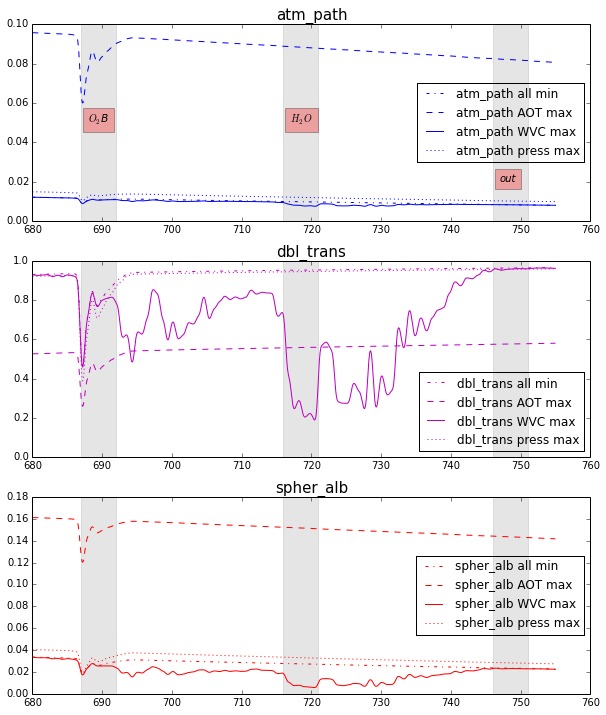

In [192]:
# The extremes...
extrem = {'AOT': (df.AOT.min(), df.AOT.max()), 'WVC': (df.WVC.min(), df.WVC.max()), 'press': (df.press.min(), df.press.max())}

# wavelength range
wvr = (716., 721.) #inside wv band
o2r = (687., 692.) #inside 02-b band
out = (746., 751.) #outside absorb bands

# wavelength mask
wls = (680., 755.)
lam = df.lam[0]
wl_mask = np.logical_and(lam >= wls[0], lam <= wls[1])
lam = lam[wl_mask]

# the masks...
allminmask = np.logical_and(df.AOT == extrem['AOT'][0], np.logical_and(df.WVC == extrem['WVC'][0], df.press == extrem['press'][0]))
AOTmaxmask = np.logical_and(df.AOT == extrem['AOT'][1], np.logical_and(df.WVC == extrem['WVC'][0], df.press == extrem['press'][0]))
WVCmaxmask = np.logical_and(df.AOT == extrem['AOT'][0], np.logical_and(df.WVC == extrem['WVC'][1], df.press == extrem['press'][0]))
pressmaxmask = np.logical_and(df.AOT == extrem['AOT'][0], np.logical_and(df.WVC == extrem['WVC'][0], df.press == extrem['press'][1]))

atm_path_allmin = df[allminmask].atm_path[0][wl_mask]
dbl_trans_allmin = df[allminmask].dbl_trans[0][wl_mask]
spher_alb_allmin = df[allminmask].spher_alb[0][wl_mask]

atm_path_aotmax = list(df[AOTmaxmask].atm_path)[0][wl_mask]
dbl_trans_aotmax = list(df[AOTmaxmask].dbl_trans)[0][wl_mask]
spher_alb_aotmax = list(df[AOTmaxmask].spher_alb)[0][wl_mask]

atm_path_wvcmax = list(df[WVCmaxmask].atm_path)[0][wl_mask]
dbl_trans_wvcmax = list(df[WVCmaxmask].dbl_trans)[0][wl_mask]
spher_alb_wvcmax = list(df[WVCmaxmask].spher_alb)[0][wl_mask]

atm_path_pressmax = list(df[pressmaxmask].atm_path)[0][wl_mask]
dbl_trans_pressmax = list(df[pressmaxmask].dbl_trans)[0][wl_mask]
spher_alb_pressmax = list(df[pressmaxmask].spher_alb)[0][wl_mask]

fig, ax = plt.subplots(3, figsize=(10,12))

ax[0].plot(lam, atm_path_allmin, 'b-.', label='atm_path all min')
ax[0].plot(lam, atm_path_aotmax, 'b--', label='atm_path AOT max')
ax[0].plot(lam, atm_path_wvcmax, 'b-', label='atm_path WVC max')
ax[0].plot(lam, atm_path_pressmax, 'b:', label='atm_path press max')
maxy = 0.1
ax[0].fill_between(wvr, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[0].fill_between(o2r, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[0].fill_between(out, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[0].legend(loc='right')
ax[0].set_ylim((0., maxy))
ax[0].set_title('atm_path', fontsize=15)
ax[0].text(np.average(o2r)-1.5, maxy/2., r'$O_2$B', style='italic',
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':10})
ax[0].text(np.average(wvr)-1.5, maxy/2., r'$H_2O$', style='italic',
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':10})
ax[0].text(np.average(out)-1.5, maxy/5, 'out', style='italic',
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':10})

ax[1].plot(lam, dbl_trans_allmin, 'm-.', label='dbl_trans all min')
ax[1].plot(lam, dbl_trans_aotmax, 'm--', label='dbl_trans AOT max')
ax[1].plot(lam, dbl_trans_wvcmax, 'm-', label='dbl_trans WVC max')
ax[1].plot(lam, dbl_trans_pressmax, 'm:', label='dbl_trans press max')
maxy = 1.0
ax[1].fill_between(wvr, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[1].fill_between(o2r, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[1].fill_between(out, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[1].legend(loc='best')
ax[1].set_ylim((0., maxy))
ax[1].legend(loc='best')
ax[1].set_title('dbl_trans', fontsize=15)

ax[2].plot(lam, spher_alb_allmin, 'r-.', label='spher_alb all min')
ax[2].plot(lam, spher_alb_aotmax, 'r--', label='spher_alb AOT max')
ax[2].plot(lam, spher_alb_wvcmax, 'r-', label='spher_alb WVC max')
ax[2].plot(lam, spher_alb_pressmax, 'r:', label='spher_alb press max')
maxy = 0.18
ax[2].fill_between(wvr, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[2].fill_between(o2r, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[2].fill_between(out, (0.0, 0.0), (maxy, maxy), color='k', alpha=0.1)
ax[2].legend(loc='best')
ax[2].set_ylim((0., maxy))
ax[2].legend(loc='best')
ax[2].set_title('spher_alb', fontsize=15)


blabla...

###Inside WV absorption band

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


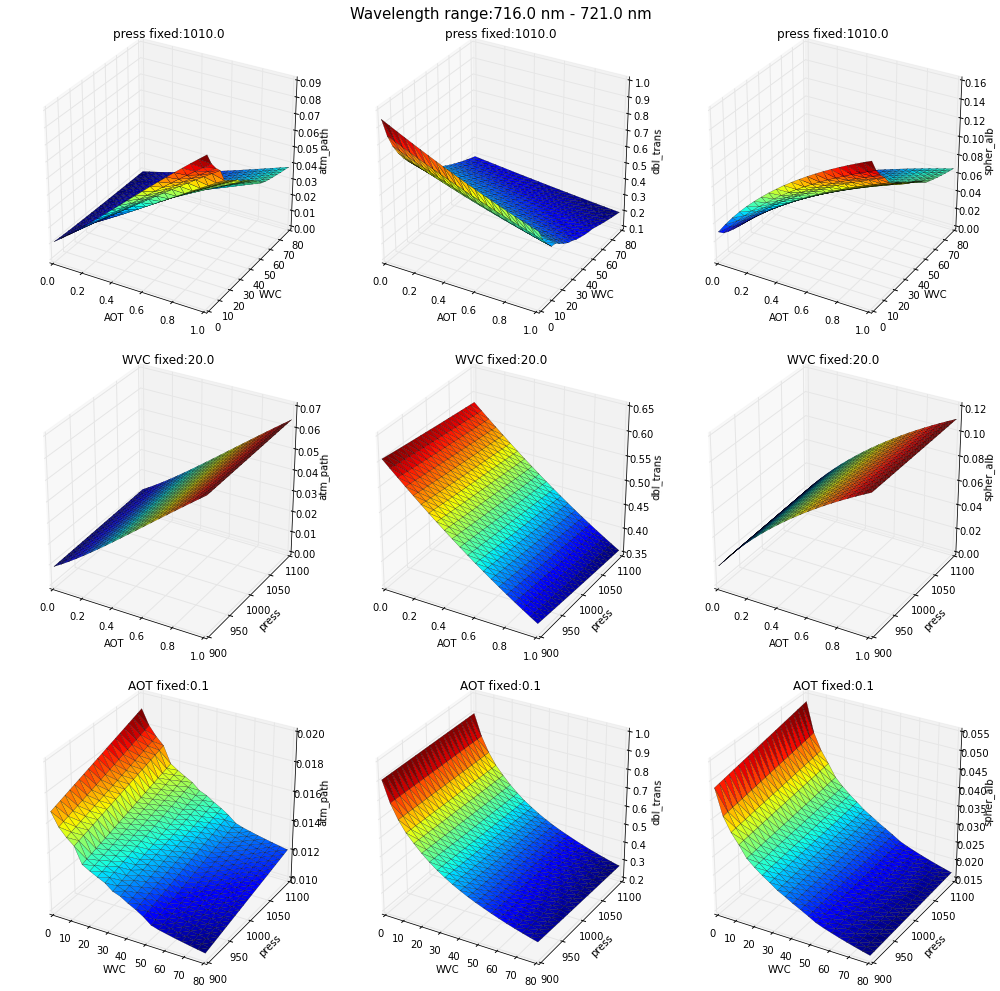

In [171]:
# select the wavelength range or ratio between wavelength ranges and the values at which to keep 
# columns fixed when comparing other columns.
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# wavelength range
# wvr = (716., 721.) #inside wv band
# o2r = (687., 692.) #inside 02-b band
# out = (746., 751.) #outside absorb bands
wls = wvr

# fixed values
fix_dict = {'AOT': 0.1, 'WVC': 20., 'press':1010.}

# RT variables
rt_vars = ['atm_path', 'dbl_trans', 'spher_alb']

# get mask of wls ranges
lam = df.lam[0]
wl_mask = np.logical_and(lam >= wls[0], lam <= wls[1])

# transform dataframe to singular values for spectra in accordance with range selection
sing_df = df[fix_dict.keys()]
for var in rt_vars:
    narr = np.average(np.vstack(df[var].values)[:,wl_mask], axis=1)
    sing_df[var] = narr

combs = list(itertools.combinations(cols, 2))
fig = plt.figure(figsize=(14,14))
fig.set_tight_layout({'pad': 1.08,'w_pad': None,'h_pad': None,'rect':  (0, 0, 1, 0.98)}) #True)
fig.suptitle('Wavelength range:%.1f nm - %.1f nm' % wls, fontsize=15 )

for i, comb in enumerate(combs):
    other = list(set(list(cols)) - set(list(comb)))[0]
    temp_df = sing_df[sing_df[other] == fix_dict[other]]
    x = temp_df[comb[0]].values
    y = temp_df[comb[1]].values
    for j, var in enumerate(rt_vars):
        z = temp_df[var].values
        pos = (j+1)+(i*len(rt_vars))
        ax = fig.add_subplot(len(combs),len(rt_vars), pos, projection='3d')
        ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)
        ax.set_xlabel(comb[0])
        ax.set_ylabel(comb[1])
        ax.set_zlabel(var)
        ax.set_title('%s fixed:%.1f' % (other, fix_dict[other]))

The changes in parameter space seem much smoother and closer to linear inside the WV absorption band than the $O_2$A band and outside the absorption bands. As in all 3 groups of plots the pressure parameter plays a very small role in the variance of the RT variables. AOT and WVC are the major players in the changes expected in variables.

Keeping pressure fixed and varying AOT and WVC we note that an increase in WVC would decrease the atmospheric path reflectance (atm_path). This is to be expected as inside the WV band more light would be absorbed thus less less reflected by the atmosphere. This relationships seems to be much stronger at higher AOT where the aerosols increase the atm_path and reach a peak at low WVC. WVC compensates for this by increasing the absorption relative to atm_path reflectance. The relationship seems more non-linear at low WVC and high AOT. At low AOT changes in WVC seems to have very little effect on changes in atm_path, although the same can not be said in the case of two way transmittance (dbl_trans). Here increases in WVC causes a marked decrease in dbl_trans, the same with the increase in AOT. The highest transmittance occurs at low AOT and WVC. Spherical albedo (spher_alb) has a similar relationship to AOT and WVC than atm_path, which can be expected, as they both are atmospheric reflectances thus influenced by the same factors. spher_alb though has a much larger range and higher peak. This increase is due to the factoring in of downward atmospheric reflectance which has been reflected back up by the earths surface. 

Keeping WVC fixed and varying AOT and pressure the smoothest and closest to linear relationships are found. Pressure again has very little influence in the typical range for the surface. Note though that there is a slight increase in atm_path with the same relationship expected for spher_alb and decrease in dbl_trans with an increase in pressure. An increase in AOT increase both spher_alb and atm_path and decreases dbl_trans. 

Keeping AOT fixed and vary WVC and pressure we note a similar relationship between all three the RT variables. Increasing WVC decreases atm_path, dbl_trans and spher_alb. This is to be expected in the water vapour absorption band, where the proportion of light reflected or transmitted by the atmosphere decreases compared to that which is absorbed. Increasing pressure increases the atm_path and spher_alb only slightly, and decreases the dbl_trans. For the reflectance variables this change is much stronger at lower WVC values. Inside the WV absorption band with very little WV in the air there is a less chance for absorption to compete with reflectance, thus reflectance both in atm_path and spher_alb peak at low WVC and high pressure. There are more atmospheric molecules which increase reflectance outside the atmospheric gas (not including WV) absorption bands which leads to a rise in reflectance and decrease in transmittance. The relationship between WVC, pressure and both dbl_trans and spher_alb is very close to linear, whereas with atm_path this relationship breaks down over the WVC range. There are some sharp steps at WVC of about 12, 16 and 52. Between them the relationship seems much more linear.

###Inside O2-B absorption band

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


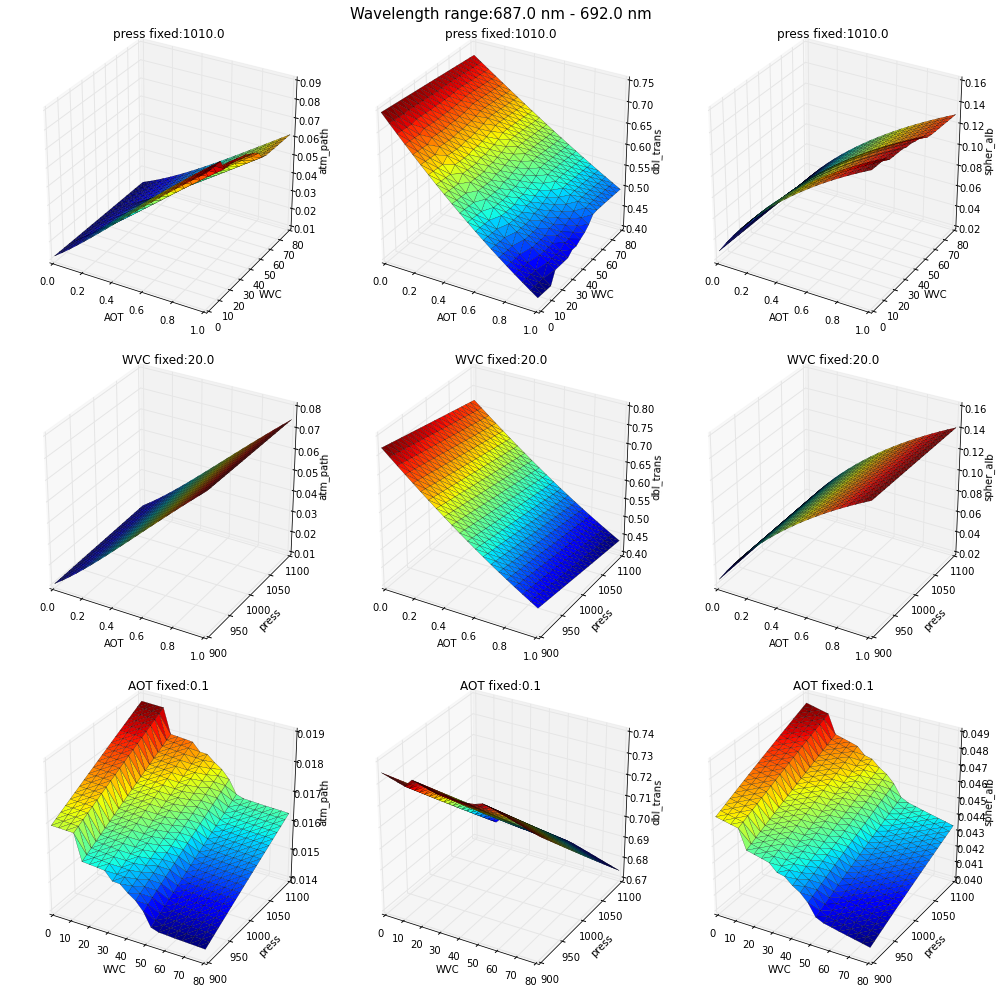

In [229]:
# select the wavelength range or ratio between wavelength ranges and the values at which to keep 
# columns fixed when comparing other columns.
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# wavelength range
# wvr = (716., 721.) #inside wv band
# o2r = (687., 692.) #inside 02-b band
# out = (746., 751.) #outside absorb bands
wls = o2r

# fixed values
fix_dict = {'AOT': 0.1, 'WVC': 20., 'press':1010.}

# RT variables
rt_vars = ['atm_path', 'dbl_trans', 'spher_alb']

# get mask of wls ranges
lam = df.lam[0]
wl_mask = np.logical_and(lam >= wls[0], lam <= wls[1])

# transform dataframe to singular values for spectra in accordance with range selection
sing_df = df[fix_dict.keys()]
for var in rt_vars:
    narr = np.average(np.vstack(df[var].values)[:,wl_mask], axis=1)
    sing_df[var] = narr

combs = list(itertools.combinations(cols, 2))
fig = plt.figure(figsize=(14,14))
fig.set_tight_layout({'pad': 1.08,'w_pad': None,'h_pad': None,'rect':  (0, 0, 1, 0.98)}) #True)
fig.suptitle('Wavelength range:%.1f nm - %.1f nm' % wls, fontsize=15 )

for i, comb in enumerate(combs):
    other = list(set(list(cols)) - set(list(comb)))[0]
    temp_df = sing_df[sing_df[other] == fix_dict[other]]
    x = temp_df[comb[0]].values
    y = temp_df[comb[1]].values
    for j, var in enumerate(rt_vars):
        z = temp_df[var].values
        pos = (j+1)+(i*len(rt_vars))
        ax = fig.add_subplot(len(combs),len(rt_vars), pos, projection='3d')
        ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)
        ax.set_xlabel(comb[0])
        ax.set_ylabel(comb[1])
        ax.set_zlabel(var)
        ax.set_title('%s fixed:%.1f' % (other, fix_dict[other]))

Inside the $O_2$B absorption band the relationships between parameters and RT variables are very similar to the previous case inside the WV absorption band, except in the case of dbl_trans and to a lesser degree with spher_alb and atm_path. Keeping pressure fixed and varying WVC and AOT we note that increasing WVC will increase the atm_path reflectance at low AOT and decrease it at high AOT. This shows that the there are hydrophilic aerosols which accrete water in the $O_2$B band even though it is outside of the major atmospheric WV absorption bands. Increasing the WVC causes the water absorbing aerosol particles to accrete and increase in size which will affect the scattering properties (Shettle. E, 1989). Even though the $O_2$B absorption band is outside of the major water absorption band there is still some water absorption continuum in this region (Liou. KN, 2002, p.85). This is shown by the similarity between the relationships in the VW absorption band previously shown and this region. Once again any relationship between WVC and any other parameter or variable is much more non-linear than between any of the other. Compared to the other bands the $O_2$B absorption band is very sensitive to pressure changes which directly impact on the amount of $O_2$ in the atmosphere, as this gas in well mixed and evenly distributed throughout the column. In this band dbl_trans is more sensitive to pressure changes than to the WVC as can be seen in the middle column bottom row of the figure above. atm_path and spher_alb are more sensitive to fluctuations in WVC than pressure, but both make very little difference to the amount of atmospheric reflectance, with transmittance influenced by $O_2$ absorption the dominant variable. Pressure can thus not be discounted as an important parameter in the eventual forward model. Pressure can not be fixed for the sake of conditioning as this would lead to errors of up to 6% in transmittance when taken over the full range of expected pressure values. 

###Steps in WVC range

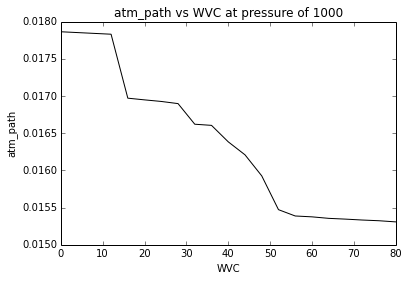

In [240]:
y = temp_df.atm_path[temp_df.press == 1000]
x = temp_df.WVC[temp_df.press == 1000]
plt.plot(x, y, 'k-')
plt.xlabel('WVC')
plt.ylabel('atm_path')
plt.title('atm_path vs WVC at pressure of 1000')

###Outside major absorption bands

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


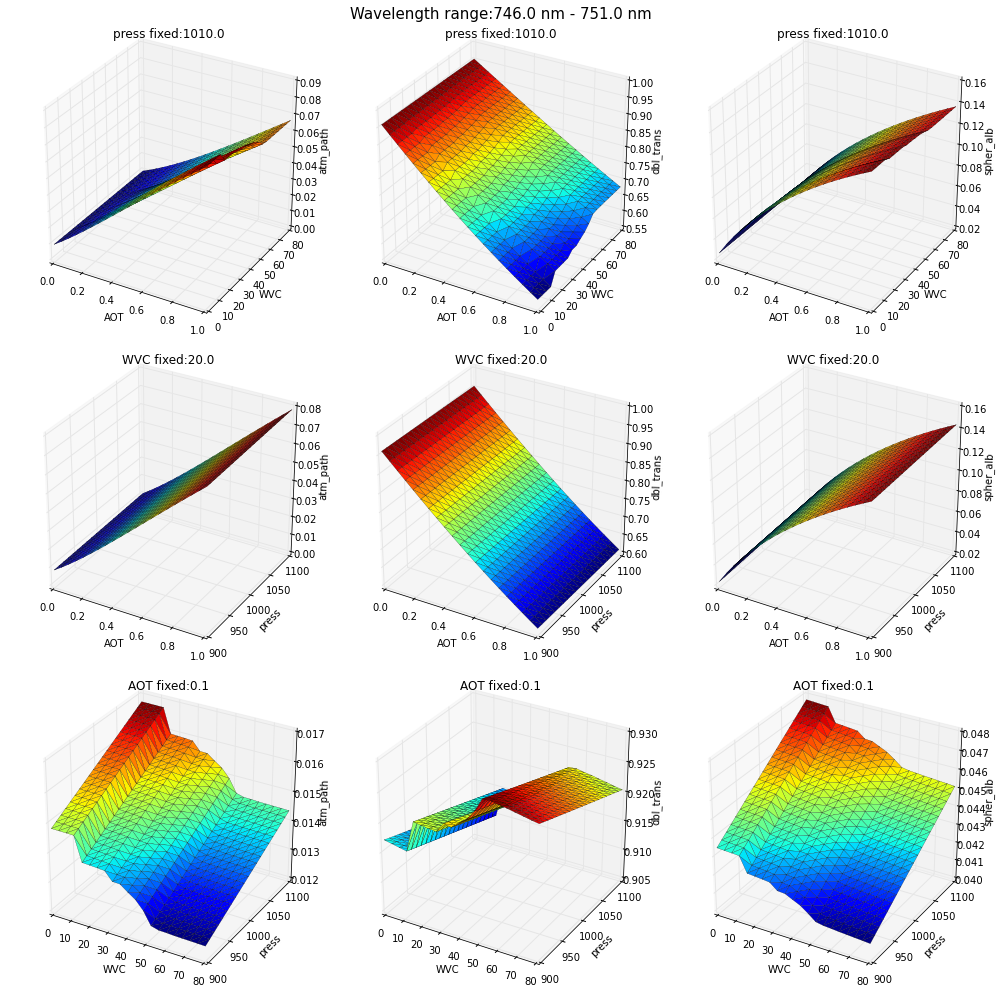

In [173]:
# select the wavelength range or ratio between wavelength ranges and the values at which to keep 
# columns fixed when comparing other columns.
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# wavelength range
# wvr = (716., 721.) #inside wv band
# o2r = (687., 692.) #inside 02-b band
# out = (746., 751.) #outside absorb bands
wls = out

# fixed values
fix_dict = {'AOT': 0.1, 'WVC': 20., 'press':1010.}

# RT variables
rt_vars = ['atm_path', 'dbl_trans', 'spher_alb']

# get mask of wls ranges
lam = df.lam[0]
wl_mask = np.logical_and(lam >= wls[0], lam <= wls[1])

# transform dataframe to singular values for spectra in accordance with range selection
sing_df = df[fix_dict.keys()]
for var in rt_vars:
    narr = np.average(np.vstack(df[var].values)[:,wl_mask], axis=1)
    sing_df[var] = narr

combs = list(itertools.combinations(cols, 2))
fig = plt.figure(figsize=(14,14))
fig.set_tight_layout({'pad': 1.08,'w_pad': None,'h_pad': None,'rect':  (0, 0, 1, 0.98)}) #True)
fig.suptitle('Wavelength range:%.1f nm - %.1f nm' % wls, fontsize=15 )

for i, comb in enumerate(combs):
    other = list(set(list(cols)) - set(list(comb)))[0]
    temp_df = sing_df[sing_df[other] == fix_dict[other]]
    x = temp_df[comb[0]].values
    y = temp_df[comb[1]].values
    for j, var in enumerate(rt_vars):
        z = temp_df[var].values
        pos = (j+1)+(i*len(rt_vars))
        ax = fig.add_subplot(len(combs),len(rt_vars), pos, projection='3d')
        ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)
        ax.set_xlabel(comb[0])
        ax.set_ylabel(comb[1])
        ax.set_zlabel(var)
        ax.set_title('%s fixed:%.1f' % (other, fix_dict[other]))

Outside of the major absorption bands the relationships can be termed stable and typical of the visible part of the spectrum. Increasing WVC at low AOT and fixed pressure has very little effect on the atm_path, dbl_trans and spher_alb. At higher AOT the interaction between aerosols and WV start to emerge as has been discussed previously in the case of the $O_2$B absorption band. This affects the scattering and absorption properties of hydrophilic aerosols. There may also be the effects of the WV continuum absorption in this region. 

In the case of a fixed WVC and varying AOT and pressure the relationships seem much smoother and close to linear. As AOT increases so scattering by aerosols increase the atm_path and spher_alb. The effects of pressure changes seem very small. Even what may seem a large increase in atm_path, decrease in dbl_trans and increase in spher_alb is small when taken over the full range of pressure changes. In the bottom row a WVC of 80 for example, the change in pressure for a fixed AOT of 0.1 is about 0.002 in atm_path, which should be similar to what is expected at fixed AOT and WVC in the middle row above. The scales can be misleading until one realises that the ranges of RT variables in the bottom row is small compared to those in the previous two rows.

In all cases we have shown that the effect of the interaction between aerosols and water vapour is the cause for most of the non-linearity of the relationships between the atmospheric parameters and the RT variables. The Hygroscopic particles increase in size with increased water vapour, and their density and refractive index also changes. The model used by Shettle (1989) was used and includes these interactions (Koepke et al, 1997). 

### Ratio between inside and outside the WV absorption band

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


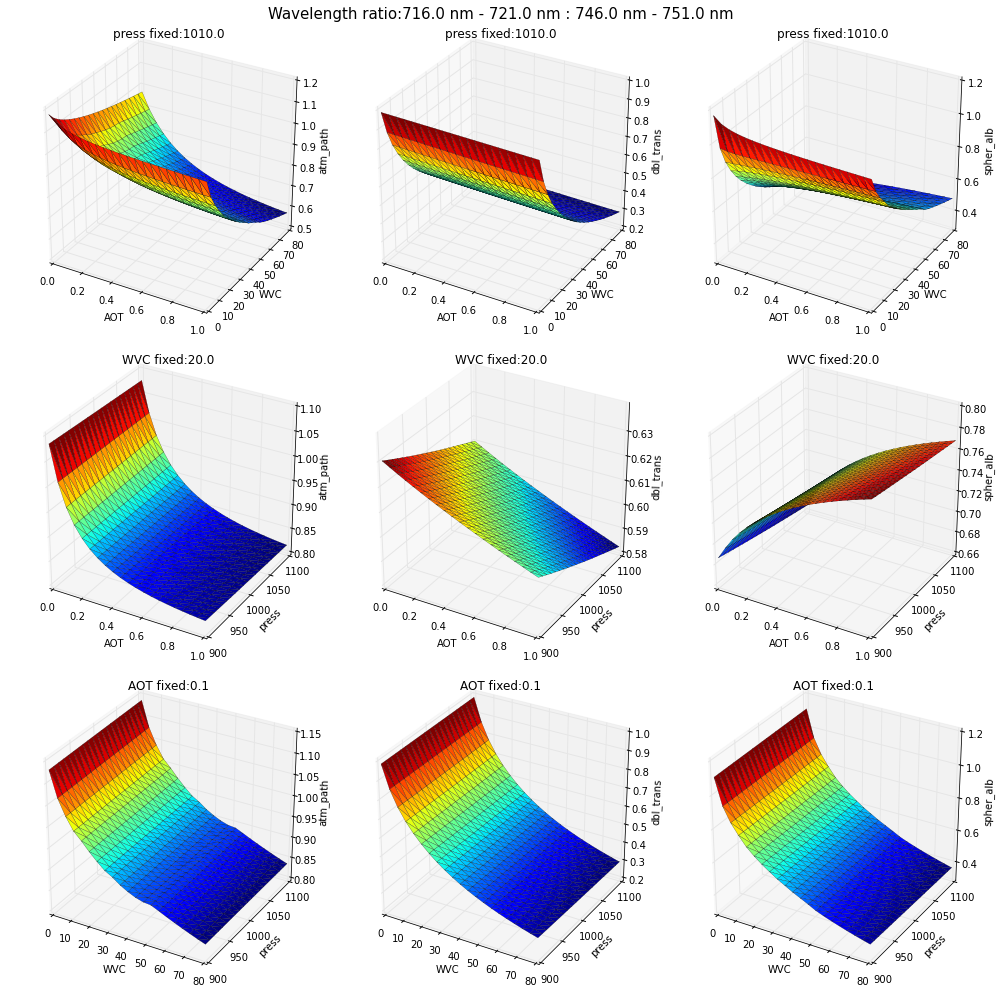

In [174]:
# select the wavelength range or ratio between wavelength ranges and the values at which to keep 
# columns fixed when comparing other columns.
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# wavelength range
# wavelength range
# wvr = (716., 721.) #inside wv band
# o2r = (687., 692.) #inside 02-b band
# out = (746., 751.) #outside absorb bands
wli = wvr # inside band
wlo = out # outside band


# fixed values
fix_dict = {'AOT': 0.1, 'WVC': 20., 'press':1010.}

# RT variables
rt_vars = ['atm_path', 'dbl_trans', 'spher_alb']

# get mask of wls ranges
lam = df.lam[0]
wl_mask_in = np.logical_and(lam >= wli[0], lam <= wli[1])
wl_mask_out = np.logical_and(lam >= wlo[0], lam <= wlo[1])

# transform dataframe to singular values for spectra in accordance with range selection
sing_df = df[fix_dict.keys()]
for var in rt_vars:
    narri = np.average(np.vstack(df[var].values)[:,wl_mask_in], axis=1)
    narro = np.average(np.vstack(df[var].values)[:,wl_mask_out], axis=1)
    sing_df[var] = narri / narro

combs = list(itertools.combinations(cols, 2))
fig = plt.figure(figsize=(14,14))
fig.set_tight_layout({'pad': 1.08,'w_pad': None,'h_pad': None,'rect':  (0, 0, 1, 0.98)}) #True)
wls = (wli[0], wli[1], wlo[0], wlo[1])
fig.suptitle('Wavelength ratio:%.1f nm - %.1f nm : %.1f nm - %.1f nm' % wls, fontsize=15 )

for i, comb in enumerate(combs):
    other = list(set(list(cols)) - set(list(comb)))[0]
    temp_df = sing_df[sing_df[other] == fix_dict[other]]
    x = temp_df[comb[0]].values
    y = temp_df[comb[1]].values
    for j, var in enumerate(rt_vars):
        z = temp_df[var].values
        pos = (j+1)+(i*len(rt_vars))
        ax = fig.add_subplot(len(combs),len(rt_vars), pos, projection='3d')
        ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)
        ax.set_xlabel(comb[0])
        ax.set_ylabel(comb[1])
        ax.set_zlabel(var)
        ax.set_title('%s fixed:%.1f' % (other, fix_dict[other]))

The first thing we notice about the ratioing compared to the different band selections is that the non-linearity wrt the interaction between AOT and WVC almost dissapears. This again points to the effect of hygroscopic aerosols which would affect adjacent wavelengths in a similar way, thus removing the sharp steps we noticed in the previous plots. Any decrease in WVC decreases all RT variables regardless. This is expected as an increase in WV would decrease the the reflectance and transmittance inside the WV absorption band compared to outside for all three of atm_path, dbl_trans, and spher_alb. The absorption competes with both reflectances in atm_path and spher_alb as well as transmittance in dbl_trans. 

In the case of a fixed pressure with varying WVC and AOT we note that an increase in AOT would decrease the ratio through the additive effect of aerosols to the atmospheric reflectance which is very similar in both regions. As the ratio is in the vacinity of 1.2 with no aerosols and no WV, thus for a perfect Rayleigh scattering atmosphere, an increase in AOT would increase the numerator and denominator of the ratio equation with almost equal amounts. The ratio in the case of increasing AOT and no influence of WV would approach a factor of about 1 as the AOT influence both numerator and denominator similarly with ever increasing AOT. See the first graph of the extremes of the AOT, where at maximum AOT the atm_path is almost the same in the WV absorption band and outside. At the high end of AOT the overwhelming effect on the atm_path would be aerosols which would be the ratio of two aerosol reflectance at wavelengths very close to eachother. Assuming that the aerosol reflectance are very similar at both wavelength regions this makes the ratio approach 1. A similar situation exists with spher_alb. Here the ratio also approaches 1 at the high end of AOT. At fixed pressure and AOT the ratio would decreases as the absorption within the WV band increases relative to outside the band. The overall minimum is reached at the highest AOT and highest WVC. Without the influence of WV the transmittance ratio between inside and outside the WV band stays quite constant and flat at about 1. Pressure and AOT affect dbl_trans similarly across the WV and outside this bands. An increase in WVC brings down the overall dbl_trans but at fixed WVC its stays quite flat for a change in AOT. Spher_alb has a similar relationship to the parameters as atm_path, except as high WVC, where an increase in AOT would increase the ratio inside and outside the WV band. This is due to the additive affect of aerosols to the ratioing equation. Both numerator and denominator are increased by similar amounts, and just like the previous example with atm_path the will approach unity if we keep on additing a constant term to both numerator and denominator. 

With WVC fixed and varying AOT and pressure very smoothly varying and close to linear relationships appear. Pressure seems to have very little influence except in dbl_trans where regardless of the AOT over the pressure range expected a 2% change in dbl_trans ratio can be expected. This points to the fact that in both the WV and outside this band any change in pressure has a similar influence to reflectance in both bands. Due to the influence of $O_3$ absorption in the Chappius bands which covers the full visible spectrum being small but not insignificant, we can only assume that any change in pressure would influence the amount of molecules in the column of air thus the amount of absorption by Ozone. The absorption cross section for Ozone is larger in the WV absorption band region than the outside band, which explains why the ratio decreases with increasing pressure (Liou. KN, 2002. p.75). atm_path ratio decreases due to the increase in atm_path inside and outside the WV band, with increasing AOT, with the outside band increasing at a greater rate. A similar situation exists with dbl_trans, except here the relationship seems more linear due to the change over the ratio happening at a lower part of the hyperbolic curve, ie the wing of the curve. The increase in spher_alb ratio is due to the increase in spher_alb both inside and outside the WV band with the increasing AOT. The increase is greater inside the WV absorption band than outside. This is due to the scattering cross section for the aerosols used being greater in the WV band than outside. 

With AOT fixed and varying WVC and pressure a similar situation exists with regards to the increasing atm_path with increasing AOT although the increase is greater in the outside band. The non-linear effects we noted with regards to the interaction between WVC and AOT is almost completely removed through ratioing, except for a slight step at WVC of 72. Pressure again plays a very small role in changes in the ratios. dbl_trans ratio portrays the same relationship with decreasing dbl_trans inside the WV band and increasing outside, thus overall decreasing the ratio. We note the non-linearity in the outside band almost dissapears through ratioing. The same can be said for spher_alb, except that the denominator is decreasing although the overall effect if for a decrease in ratio.

To be learnt from this exercise is that the interaction between WVC vs AOT or press is highly non-linear and thus should be samples at a higher frequency in the LUT to pick up the major steps in the relationship. The relationship between AOT vs pressure is very linear and needs fewer points. When considered over WVC to AOT or WVC to pressure the steps are across the WVC parameter space and are smoothly varying across AOT and pressure, thus sampling does not need to be that high over AOT or pressure as over WVC. Another approach could be to sample at a higher frequency in the areas which portray the greatest non-linearities and less so in smoothly varying regions of the WVC parameter space. The region between 60 and 80 is quite flat and between 0 and 12. 

###Variation of RT variables with altitude changes

It can be assumed that altitude would have a similar effect to the RT variables as pressure, as pressure decreases with increasing altitude. We never the less tested the relationship relying on values of typical AOT, pressure, and WVC per altitude. The values are based on The US-Standard atmosphere from Anderson et al (1986) for pressure and WVC, and an AOT profile from Elterman (1968).  Altitude would be a prescribed parameter in the Emulator and would thus not need to be retrieved during the inversion process. A series of libRadtran runs were performed between an altitude of MSL (0) to 5 km AMSL. Values which were in moles per $cm^3$ were converted to $kg/m^2$ using a a molar mass of 18.01528 g/mol of water.

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


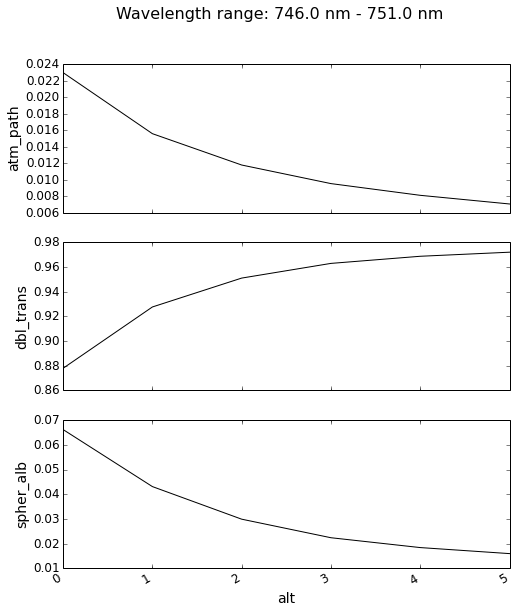

In [77]:
import glob
import cPickle

files = glob.glob('lut_40.0_20.0_45.0_*.p')
alt_dicts = []
for f in files:
    fl = open(f, 'rb')
    fl = cPickle.load(fl)
    alt_dicts.append(fl)
alt_df = pd.DataFrame(alt_dicts)

# wavelength range
wvr = (716., 721.) #inside wv band
o2r = (687., 692.) #inside 02-b band
out = (746., 751.) #outside absorb bands
wls = out

# fixed values
paras = ['AOT', 'WVC', 'press', 'alt']

# RT variables
rt_vars = ['atm_path', 'dbl_trans', 'spher_alb']

# get mask of wls ranges
lam = alt_df.lam[0]
wl_mask = np.logical_and(lam >= wls[0], lam <= wls[1])

# transform dataframe to singular values for spectra in accordance with range selection
sing_df = alt_df[paras+rt_vars]
for var in rt_vars:
    narr = np.average(np.vstack(alt_df[var].values)[:,wl_mask], axis=1)
    sing_df[var] = narr

sing_df = sing_df.set_index('alt').sort_index(axis=0)
title = 'Wavelength range: %.1f nm - %.1f nm' % wls
axes = sing_df.plot(y=rt_vars, subplots=True, sharex=True, legend=False, figsize=(8,10), fontsize=12)
axes[0].set_ylabel(rt_vars[0], fontsize=14)
axes[1].set_ylabel(rt_vars[1], fontsize=14)
axes[2].set_ylabel(rt_vars[2], fontsize=14)
axes[2].set_xlabel('alt', fontsize=14)
plt.suptitle(title, fontsize=16)


In the model the profiles of moleculare absorbers and reflectors which are not forced are cut at the specified altitude, whereas the aerosol profile and forced column values such as WVC and pressure always starts at the surface (Mayer. B et al, 2014). This necessitated us to use prescribed values as opposed to simply increasing the altitude per run with fixed AOT, WVC and pressure. A rural profile with continental average aerosol species model was used with most aerosols confined below the boundary layer (Shettle, 1989). By defining a fixed AOT and WVC we are in fact forcing the column values between the surface elevation and above to these values and not between MSL and above. The analysis of the graphs above shows that atm_path decreases as would be expected with increasing surface elevation. This is due to the reduction in scattering gas molecules and particles in the atmospheric column as surface elevation increases. With dbl_trans the relationship is reversed. Transmittance increases as would be expected with increasing surface elevation and a decreasing gaseous and particle column. Spher_alb shows a natural decrease in reflectance with increasing elevation.

In [1]:
# what about global sensitivity based methods to assess the parameters that affect the variance of variables the most.
# see Saltelli book. We should have enough data to be able to assess the effects of changing parameters on the variables.

## PCA of the RT variables

We have distributions of AOT, press and WVC but do not have one for alt. To start off we have to get a distribution of the global surface altitude. For this a SRTM global DEM was downloaded and altitudes over the land mass were binned into a histogram. A distribution type was selected based on the shape of the histogram and test simulations with the distribution of the best fit selected. In order to reduce the amount of simulations for solar zenith angles a usefull thing to have would be the range of solar zenith angles we could expect to encounter for the MetopA orbit and the swathe of the GOME-2 sensor.

### Solar zenith angle range

In [2]:
# functions to calculate bearing from 2 coordinates and coordinate from coordinate, bearing and distance.
import pdb

def dms_dec(dms):
    '''A function that converts degrees minutes seconds to decimal degrees.
    Input: dms
    Output: dec
    ''' 
    neg = True if dms < 0.0 else False
    dms = np.abs(dms)
    dmsstr = '%.10f' % (dms)
    degrees = np.trunc(dms)
    right = dmsstr.split('.')[1]
    minutes = right[:2]
    seconds = right[2:]
    dec = degrees + np.float(minutes)/60 + np.float(seconds)/60/60/(10**(len(seconds)-2))
    dec = -dec if neg else dec
    return dec    

def add_deg(deg1, deg2):
    '''Adds two angles in decimal degrees and convert to 0 to 360 degree convention.
    Both angles have to be between 0 and 360.
    Input: deg1, deg2
    Output: deg360
    '''
    deg = deg1 + deg2
    deg = deg if deg < 360 else deg - 360
    return deg

def sub_deg(deg1, deg2):
    '''Subtracts two angles in decimal degrees and convert to 0 to 360 degree convention.
    Both angles have to be between 0 and 360.
    Input: deg1, deg2
    Output: deg360
    '''
    deg = deg1 - deg2
    deg = deg if deg >= 0 else 360 + deg
    return deg

# standard earth radius
EARTH_RADIUS = 6371.00

def geo_coord(lon, lat, bearing, distance):
    '''A function to calculate the geographic coordinates of a point based on the distance from 
    another point, its bearing from that point and its distance from that point. Angles are in
    decimal degrees and distance in kms.
    Input: lat, lon, bearing, distance
    Output: tuple(new_lat, new_lon)
    '''
    # convert Latitude and Longitude
    # into radians for calculation
    latitude = np.radians(lat)
    longitute = np.radians(lon)

    # calculate next latitude
    next_latitude = np.arcsin(np.sin(latitude) *
                    np.cos(distance/EARTH_RADIUS) +
                    np.cos(latitude) *
                    np.sin(distance/EARTH_RADIUS) *
                    np.cos(np.radians(bearing)))

    # calculate next longitude
    next_longitude = longitute + (np.arctan2(np.sin(np.radians(bearing)) *
                                             np.sin(distance/EARTH_RADIUS) *
                                             np.cos(latitude),
                                             np.cos(distance/EARTH_RADIUS) -
                                             np.sin(latitude) *
                                             np.sin(next_latitude)
                                            )
                                 )

    # convert points into decimal degrees
    new_lat = np.degrees(next_latitude)
    new_lon = np.degrees(next_longitude)
    
    return (new_lon, new_lat)

def geo_bearing(lon1, lat1, lon2, lat2):
    '''A function that calculates the bearing and distance between two geographic coordinates.
    Based on Haversine forumula. Angles are in decimal degrees and distance in kms.
    Input: lat1, lon1, lat2, lon2
    Output: tuple(bear, dist)
    '''
    # convert decimal degrees to radians 
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    
    dist = c * EARTH_RADIUS
    
    bear =np.arctan2(np.sin(lon2-lon1)*np.cos(lat2) , np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1))
    bear = np.rad2deg(bear)
    bear = (bear + 360.) % 360. # for negative angles
    
    return (bear, dist)

In [3]:
# run a simulation of the sub satellite solar zenith angle over the year 2007. will need to get the position every couple
# of minutes and then calculate the sub-satellite point for that moment and calculate the solar zenith angle. write it
# to a pandas dataframe. The information needed is solar zenith, lat, lon, utc time. 
# easy enough to convert this to an extreme of swathe solar zenith by spherical trigonometry. if we know the bearing
# between 2 points and assume a swathe bearing perpendicular to this, and know the swathe width we can work out the 
# positions of the 2 exteme points on the swathe. Only need to work out the solar zenith angle at these 2 points.
# swath is 1920 km.

from pyorbital.orbital import Orbital
from pyorbital import astronomy
from dateutil import rrule
from datetime import datetime, timedelta
import pandas as pd

# create the time list
times = []
# change start and end dates to reduce processing during testing
start = datetime(2007, 1, 1, 0, 0, 0) #start = datetime(2007, 1, 1, 0, 0, 0)
end = datetime(2007, 12, 31, 23, 59, 59) #end = datetime(2007, 12, 31, 23, 59, 59)
for dt in rrule.rrule(rrule.MINUTELY, interval=10, dtstart=start, until=end):
    times.append(dt)

# create the solar zenith angle dataframe
columns = ['lat', 'lon', 'szen']
pos = ['left', 'centre', 'right']*len(times)

times3 = [x for pair in zip(times,times,times) for x in pair]
szen_df = pd.DataFrame(index=[times3, pos], columns=columns)
szen_df.index.names = ['time', 'pos']
szen_df.name = 'subsat_sol_zen'

# read in tles into series based on time as index
fn = 'sat29499.txt'
tle_l = open(fn).read().splitlines()
tle_l = tle_l[5:]
tle_l = zip(*[iter(tle_l)]*2)
dates = [datetime(int('20'+i[0][18:20])-1, 12, 31) + timedelta(days=(float(i[0][20:32]))) for i in tle_l]
tle_sr = pd.Series(tle_l, index=dates)
tle_sr.index.name = 'dates'
tle_sr.name = 'TLEs'

# work out the solar zenith angles depending on subsatellite and extreme swath positions
olat = False
olon = False
hswath = 1920./2 # half the swath

for time in times:
    tle = tle_sr.asof(time)
    #
    if isinstance(tle, tuple):
        pass
    elif np.isnan(tle):
        continue
    # read orbital tle data
    orb = Orbital("Metop-A", line1=tle[0] , line2=tle[1] )
    # the subsatellite point
    lon, lat, alt = orb.get_lonlatalt(time)
    szen = astronomy.sun_zenith_angle(time, lon, lat)
    pos = 'centre'
    szen_df.ix[time].ix[pos].lon = lon
    szen_df.ix[time].ix[pos].lat = lat
    szen_df.ix[time].ix[pos].szen = szen
    # the left and right extreme swath points
    if olat==False:
        olat = lat
        olon = lon
        continue
    bear = geo_bearing(lon, lat, olon, olat)[0] # in reverse, back to previous point
    bear = add_deg(bear, 180.) # corrected going forward
    # the left
    lbear = sub_deg(bear, 90.)
    llon, llat = geo_coord(lon, lat, lbear, hswath)
    lszen = astronomy.sun_zenith_angle(time, llon, llat)
    pos = 'left'
    szen_df.ix[time].ix[pos].lon = llon
    szen_df.ix[time].ix[pos].lat = llat
    szen_df.ix[time].ix[pos].szen = lszen
    # the right
    rbear = add_deg(bear, 90.)
    rlon, rlat = geo_coord(lon, lat, rbear, hswath)
    rszen = astronomy.sun_zenith_angle(time, rlon, rlat)
    pos = 'right'
    szen_df.ix[time].ix[pos].lon = rlon
    szen_df.ix[time].ix[pos].lat = rlat
    szen_df.ix[time].ix[pos].szen = rszen
    
    olat = lat.copy()
    olon = lon.copy()

In [9]:
# save the satellite orbit dataframe to a file
fn = 'orbit_szen.pkl'
szen_df.to_pickle(fn)

In [12]:
# load the dataframe if required
fn = 'orbit_szen.pkl'
szen_df = pd.read_pickle(fn)

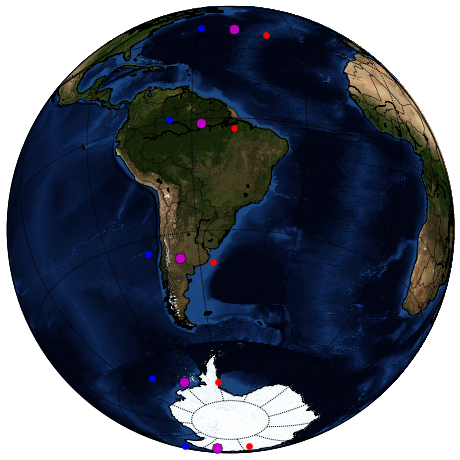

In [13]:
# Test the orbits to see if agrees with our GOME-2 observations and it does. I checked the solar zeniths
# at the extremes of the swath and it agrees to within 1 degree. The orbit below is the same used for our
# Amazon data.

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import numpy as np
%matplotlib inline

start = datetime(2007, 1, 25, 12, 49, 0)
end = datetime(2007, 1, 25, 14, 30, 0)
projection = 'ortho' # 'robin', 'ortho'. ortho doesn't accept text labels. use cyl or robin
lat_0 = -30. # latitude of viewpoint
lon_0 = -50. # longitude of viewpoint

# due to making a copy of a subset of a dataframe keeps the original index, need to move the index into
# the columns, do the subselection and then move it back into the index, thus keeping only the 
# index subset instead of the original index.
orb_df = szen_df.reset_index(level='pos').loc[start:end].set_index('pos', append=True)

# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1

my_map = Basemap(projection=projection, lat_0=lat_0, lon_0=lon_0,
              resolution='l', area_thresh=1000.0) 

plt.figure(figsize=(12,8))
 
my_map.drawcoastlines()
my_map.drawcountries()
#my_map.fillcontinents(color='coral')
my_map.bluemarble()
my_map.drawmapboundary()
 
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))

llons = orb_df['lon'].xs('left', level='pos').values
llats = orb_df['lat'].xs('left', level='pos').values
clons = orb_df['lon'].xs('centre', level='pos').values
clats = orb_df['lat'].xs('centre', level='pos').values
labels = orb_df.index.levels[0]
rlons = orb_df['lon'].xs('right', level='pos').values
rlats = orb_df['lat'].xs('right', level='pos').values

xl,yl = my_map(llons, llats)
my_map.plot(xl, yl, 'r.', markersize=12)
xc,yc = my_map(clons, clats)
my_map.plot(xc, yc, 'mo', markersize=10)
# offsets
if projection!='ortho':
    off = 2
    for x, y, label in zip(xc, yc, labels):
        plt.text(x+off, y+off, label.strftime('%Y-%m-%d %H:%M:%S'))
xr,yr = my_map(rlons, rlats)
my_map.plot(xr, yr, 'b.', markersize=12)

plt.show()

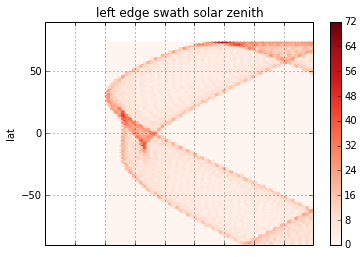

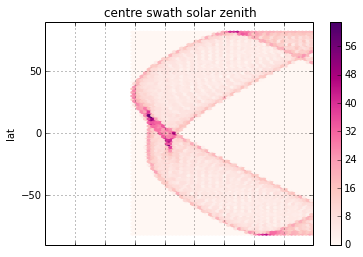

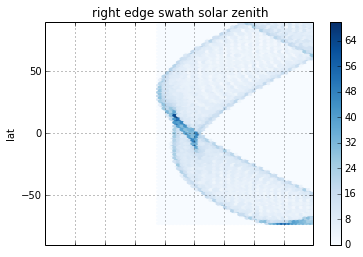

In [18]:
# plot the latitudes against solar zenith angles
%matplotlib inline

#plt.hexbin(x=szen_df.dropna().szen.values, y=szen_df.dropna().lat.values, cmap='Reds')
#plt.xlabel('szen')
#plt.ylabel('lat')
#plt.xlim(0,90)
#plt.ylim(-90,90)

szen_df.xs('left', level='pos').plot(x='szen', y='lat', xlim=(0,90), ylim=(-90,90), kind='hexbin', colormap='Reds',\
        title='left edge swath solar zenith', grid=True)
szen_df.xs('centre', level='pos').plot(x='szen', y='lat', xlim=(0,90), ylim=(-90,90), kind='hexbin', colormap='RdPu',\
        title='centre swath solar zenith', grid=True)
szen_df.xs('right', level='pos').plot(x='szen', y='lat', xlim=(0,90), ylim=(-90,90), kind='hexbin', colormap='Blues',\
        title='right edge swath solar zenith', grid=True)

# note how the left swath edge has a lower maximum norhtern latitude as it should be. With inclination at .... on the 
# daytime side cwith a north to south node crossing the latitude on the same scan of the left edge will always be less 
# than the centre or the right edge. The opposite is true for the southern hemisphere.
# The right swath edge has the higher solar zenith angle due to being on the far side opposite the sun. Norhern extremes
# on bands/strips made are the June solstice solar zenith values, and southern extremes the December solstice values.
# the range for accepted solar zenith angles for all daytime orbits globally is between 20 and 90 degrees.

To note is the characteristic peak of highest sun elevation or in other terms lowest solar zenith located in the Northern hemisphere at about 30 degrees north. This is due to the the orbit crossing lines of longitude in a east to west direction during the decending part on the day side of the globe. The part of the orbit north of the equator would be further east thus having a later local time than the part of the equator in the southern hemisphere. This translates to higher sun elevation in the north. This tendency can be seen as well in all solar zenith angles in the northern hemisphere being small or in other words higher solar elevation angles between corresponding latitudes in the northern and southern hemisphere. See ranges at 50 and -50 and note the range is shifted to higher solar elevation in the northern hemisphere.

### Global altitude distribution

<matplotlib.colorbar.Colorbar instance at 0x7fa7ea976320>

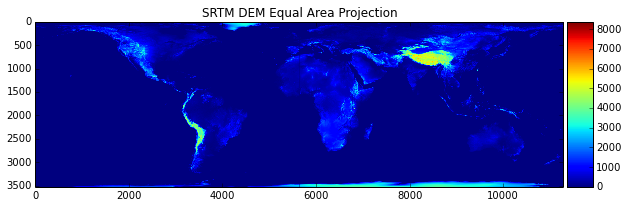

In [32]:
# DEM data in topo30_equal_area_land.tif
# The DEM was reprojected into a cylindrical equal area projection in order to make the sampled pixel size
# more representative of real world areas.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from osgeo import gdal

fn = '../../Data/DEM/topo30_equal_area_land_coarse.tif'
ds = gdal.Open(fn)
dem = np.array(ds.GetRasterBand(1).ReadAsArray())

plt.figure(figsize=(10,7))
ax = plt.gca()
plt.title('SRTM DEM Equal Area Projection')
im = plt.imshow(dem)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

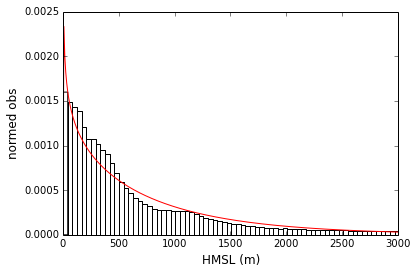

(2.2294640000085049, 762.57514668790009, 848.95216904700931)


In [130]:
# fit the data to a distribution
import scipy.stats as stats

dem_flat = np.array(dem).flatten()
dem_flat = dem_flat[~np.isnan(dem_flat)]
dem_flat = dem_flat[dem_flat>0]

# select a random sample without replacement 
# REMOVE THIS FOR FINAL SIMULATION!!!!!
#nr = 20000 # sample
#dem_flat = np.random.choice(dem_flat, nr, replace=False)

weights = np.ones_like(dem_flat)/len(dem_flat)

y = dem_flat

# the following distributions were tested with the pearsons III doing the best:
# weibull_min, f, chi2, frechet_r, gamma, pearson3
dist = stats.pearson3

x = np.linspace(0, y.max(), 1000, endpoint=True)
# fit
param_dem = dist.fit(y) #shape, loc, scale
pdf_fitted = dist.pdf(x, *param_dem)
plt.plot(x, pdf_fitted, color='r')

# plot the histogram 
plt.hist(y, bins=200, color='w', normed=True)
plt.xlim(0,3000)
#plt.ylim(0,0.002)
plt.ylabel('normed obs', fontsize='large')
plt.xlabel('HMSL (m)', fontsize='large')
plt.show()
print 'shape:%.5e, loc:%.5e, scale:%.5e' %param_dem #(2.229464, 762.5751466879, 848.952169047)

###LUT for emulator generation

In [44]:
%%html
<style>
table {float:left}
</style>

A training look-up table of libRadtran spectral atm_path, dbl_trans, and spher_alb, toa_refl and surf_refl was created for a sample of 200 latin-hypercube generated parameters. The descriptive parameters were WVC, AOT, alt, press, a and p. Individual angle configurations merited individual LUTs so that in total 936 angle configurations were selected. A separate validation LUT with 300 latin-hypercube generated parameters was also created with the same angle sets. The angle sets and parameter ranges are in the table below:

| Angles | Values or ranges               |
|:-------|:-------------------------------|
|SZA     | 10, 20, 30, 40, 50, 60, 70, 80 |
|VZA     | 0, 10, 20, 30, 40, 50, 60, 70, 80 |
|RAA     | 0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180 |
|AOT     | 0. - 1. |
|WVC     | 0. - 80. kg / m^2|
|press   | 500. - 1100 hPa |
|alt     | 0. - 5 km |
|a *     | 0. - 1. |
|p *     | 0. - 1. |
| |\* with a + p <= 1. | 


## libRadtran simulations for the LUTs

The training and validation LUTs were used to create simulations of atm_path, dbl_trans, spher_alb and toa_refl. Tell more about how libradtran was set up to do the simulations...

## Emulator generation

Emulators were generated for each angle set using the 250 training samples and 300 validation samples....

### Emulator validation

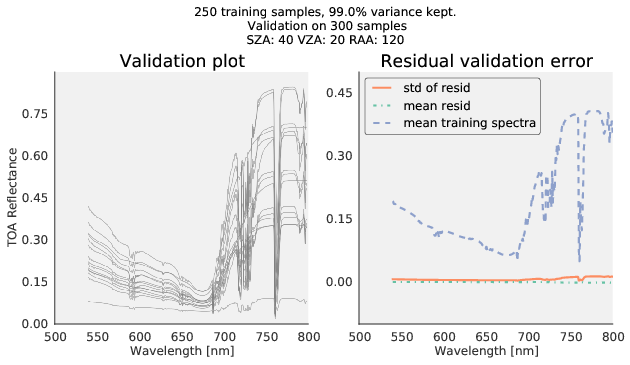

In [8]:
from wand.image import Image as WImage
img = WImage(filename='../../Data/LUT/lhd300_validate_ap/diagnostics/validation_plot_40_20_120.pdf')
img

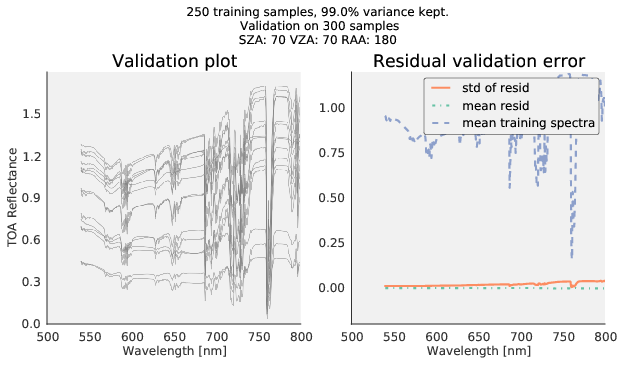

In [9]:
img = WImage(filename='../../Data/LUT/lhd300_validate_ap/diagnostics/validation_plot_70_70_180.pdf')
img

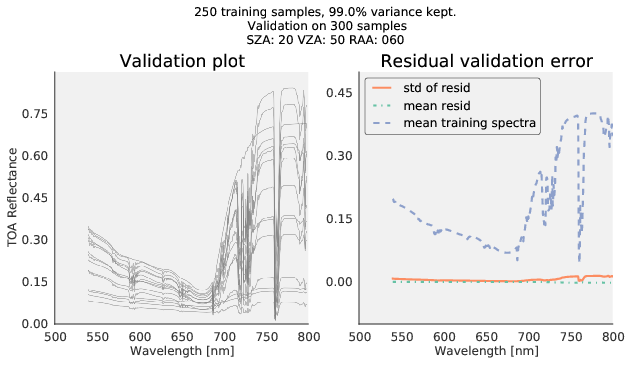

In [11]:
img = WImage(filename='../../Data/LUT/lhd300_validate_ap/diagnostics/validation_plot_20_50_060.pdf')
img

In [361]:
# like to try some individual simulations to see how well they fit
import gp_emulator
import os
import glob
sza = 30
vza = 70
raa = 75
root = '../../Data/LUT/lhd300_validate_ap'
path = os.path.join(root, str(int(sza)), str(int(vza)), str(int(raa)))
if os.path.exists(path):
    print 'path exists: %s' % path
else:
    print 'path doesn\'t exist: %s' % path
    print 'try a new one.'
    exit

#list of files and their parameters
fns = glob.glob(os.path.join(path, '*.p'))
for i, f in enumerate(fns):
    f = f.split('_')
    f[-1] = f[-1].split('.p')[0]
    f[-6] = f[-6].split('/')[-1]
    f = f[2:]
    print 'file nr: %i' % i
    print 'alt: %s km, AOT: %s, WVC: %s kg/m2, press: %s hPa, a: %s, p: %s' % tuple(f)

path exists: ../../Data/LUT/lhd300_validate_ap/30/70/75
file nr: 0
alt: 2.82001277 km, AOT: 0.79528602, WVC: 36.41822950 kg/m2, press: 1033.40105420 hPa, a: 0.12634186, p: 0.49320344


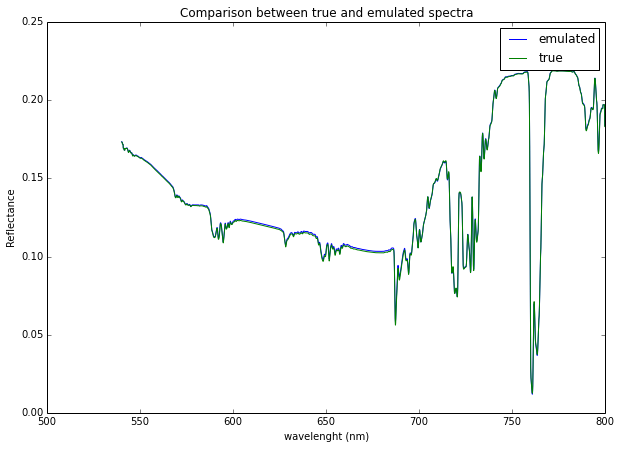

In [362]:
#select file nr above and load the file data from pickle
import pickle

# file nr above
fnr = 0

h5_emu = '../../Data/LUT/libradtran_emulators.h5'

fn = fns[fnr]
fl = open(fn, 'rb')
pkl = pickle.load(fl)
AOT = pkl['AOT']
WVC = pkl['WVC']
alt = pkl['alt']
press = pkl['press']
a = pkl['a']
p = pkl['p']
toa_refl = pkl['toa_refl']
lam = pkl['lam']

#load emulator
import gp_emulator
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=sza, vza=vza, raa=raa)

#load mean spectra file
import h5py
h5_mean = h5py.File('../../Data/LUT/mean_signal.h5', 'r')
grp = '%s_%s_%s' % (sza, vza, raa)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]

# emulate based on above parameters and add mean spectra
y = (WVC, AOT, alt, press, a, p)
toa_refl_emu = emu.predict(y)[0] + mean_toa_refl

#plot the true and emulated spectra
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(10,7))
plt.plot(lam, toa_refl_emu, label='emulated')
plt.plot(lam, toa_refl, label='true')
plt.title('Comparison between true and emulated spectra')
plt.legend(loc='best')
plt.xlabel('wavelenght (nm)')
plt.ylabel('Reflectance')